Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_21 (GaussianN (None, 1, 1)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Test Score: 69.23 RMSE
Train Score: 27.91 RMSE
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_22 (GaussianN (None, 6, 1)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 4)             

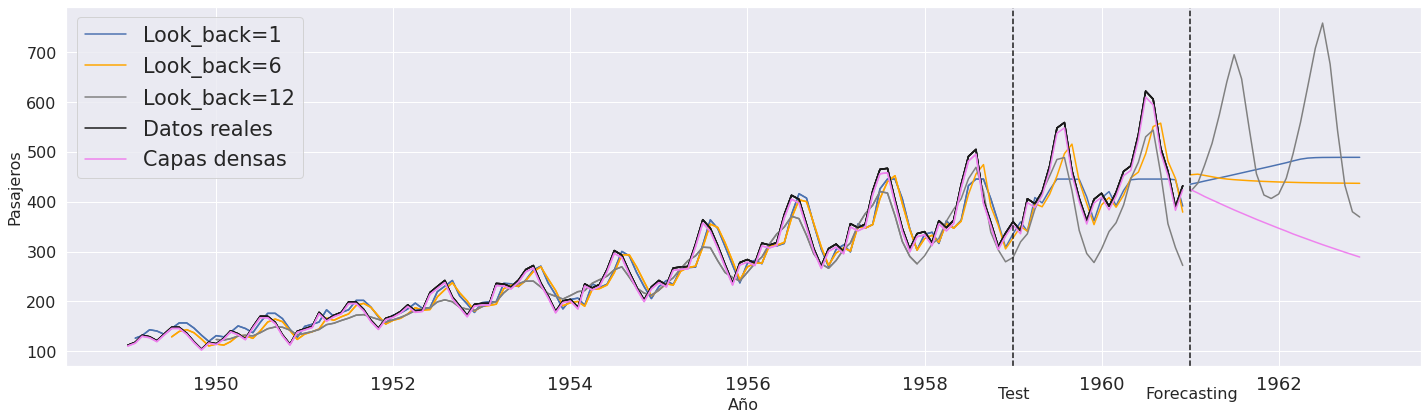

In [ ]:
# -*- coding: utf-8 -*-
"""TP7_MVK.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/17tFdl4zaSWC5EsVOB6IZXUMrZ2Zjm6Gm
"""

from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import DateOffset
from keras.layers import GaussianNoise,Dense,LSTM, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import mean_squared_error
sns.set()
data = pd.read_csv("airline-passengers.csv")
#Convierte al string asociado al mes en un objeto de Python date_time
data["Month"] = pd.to_datetime(data["Month"])
#Seteo al mes como el índice para acceder a cada fila (indice)
#Seteo que las modificaciones sean inplace (sobre el mismo objeto)
data.set_index("Month", inplace=True)
#Cambio el nombre de la variable y del indice
data.columns = ["passengers"]
data.index.name = "date" 
epoc =100
n_features = 1
n=2
fig,ax=plt.subplots(figsize=(20, 6))
c=['b','orange','grey','violet']
z=0
years_test=2
for n_input in [1,6,12]:
  #Separo years_test años para usar como datos de test
  train_data = data[:len(data)-12*years_test]
  test_data = data[len(data)-12*years_test-n_input:]

  #Normalizo los datos entre 0 y 1
  scaler = MinMaxScaler()
  scaler.fit(data)
  train = scaler.transform(train_data)
  test = scaler.transform(test_data)
  #Genero la secuencia temporal pueda ser usada como input en una capa LSTM y le agrego ruido
  generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
  generator_test = TimeseriesGenerator(test, test, length=n_input, batch_size=1)

  model = Sequential()
  model.add(GaussianNoise(0.02,input_shape=(n_input, n_features)))
  model.add(LSTM(4,activation='relu'))
  model.add(Dense(1))
  opt=Adam(learning_rate=1e-3)
  model.compile(optimizer=opt, loss='mse')
  model.fit(generator,epochs=epoc, verbose= 0)
  model.summary()

  trainPredict=model.predict(generator)
  testPredict=model.predict(generator_test)

  trainPredict = scaler.inverse_transform(trainPredict)
  testPredict = scaler.inverse_transform(testPredict)

  trainY = scaler.inverse_transform(generator.data)
  testY = scaler.inverse_transform(generator_test.data)
  trainScore = np.sqrt(mean_squared_error(trainY[n_input:], trainPredict))
  testScore = np.sqrt(mean_squared_error(testY[n_input:], testPredict))
  print('Test Score: %.2f RMSE' % (testScore))
  print('Train Score: %.2f RMSE' % (trainScore))

  dataset=scaler.transform(data.values)
  pred_list=[]
  pred_list=trainPredict
  pred_list=np.append(pred_list,testPredict)
  df_predict = pd.DataFrame(pred_list,index=data[n_input:].index, columns=['Prediction'])
  df_test = pd.concat([data,df_predict], axis=1)

  ax.plot(data.index, df_test['passengers'],color='k')
  ax.plot(df_test.index, df_test['Prediction'], color=c[z])
  ax.plot(df_test.index[:len(trainPredict)], df_test['Prediction'][:len(trainPredict)], 
          color=c[z])

  train = data
  scaler.fit(train)
  train = scaler.transform(train)
  generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
  model.fit(generator,epochs=epoc, verbose= 0);
  pred_list = []  
  n_pred=int(12*n)
  batch = train[-n_input:].reshape((1, n_input, n_features))
  for i in range(n_pred):
      pred_list.append(model.predict(batch)[0])      
      batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

  add_dates = [data.index[-1] + DateOffset(months=x) for x in range(n_pred+1) ]
  future_dates = pd.DataFrame(index=add_dates[1:],columns=data.columns)
  df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                            index=future_dates[-n_pred:].index, columns=['Prediction'])

  df_proj = pd.concat([data,df_predict], axis=1)
  lab='Look_back={}'.format(n_input)
  ax.plot(df_proj.index, df_proj['Prediction'], color=c[z],label=lab)
  z+=1

n_input=1
model = Sequential()
model.add(GaussianNoise(0.02,input_shape=(n_input, n_features)))
model.add(Dense(33, activation='relu',use_bias=True))
model.add(Dropout(0.2))
model.add(Dense(1))
train = data[:len(data)-12*years_test]
test = data[len(data)-12*years_test:]
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(test, test, length=n_input, batch_size=1)
opt=Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='mse')
model.fit(train,generator.data,epochs=epoc, verbose= 0)
model.summary()
lab='Capas densas'

trainPredict=model.predict(train)
testPredict=model.predict(test)

pred_list=[]
pred_list=trainPredict
pred_list=np.append(pred_list,testPredict)
df_predict = pd.DataFrame(pred_list,index=data.index, columns=['Prediction'])
df_test = pd.concat([data,df_predict], axis=1)

ax.plot(data.index, df_test['passengers'],color='k',label='Datos reales')
ax.plot(df_test.index, df_test['Prediction'], color=c[z])
ax.plot(df_test.index[:len(trainPredict)], df_test['Prediction'][:len(trainPredict)], 
        color=c[z])

train = data['passengers']

generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)
model.fit(train,generator.data,epochs=epoc, verbose= 0);
pred_list = []  
n_pred=int(12*n)
batch = np.array(data['passengers'][-n_input:]).reshape((1, n_input, n_features))
for i in range(n_pred):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[pred_list[i]],axis=1)
pred_list=np.reshape(pred_list,(len(pred_list),n_input))
add_dates = [data.index[-1] + DateOffset(months=x) for x in range(n_pred+1) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=data.columns)
df_predict = pd.DataFrame(pred_list,
                          index=future_dates[-n_pred:].index, columns=['Prediction'])

df_proj = pd.concat([data,df_predict], axis=1)
ax.plot(df_proj.index, df_proj['Prediction'], color=c[z],label=lab)
ax.axvline(data.index[len(data)-12*years_test],ls='--',c='k')
plt.text(data.index[len(data)-12*years_test-2],5,'Test',rotation=0,fontsize=16)
ax.axvline(df_proj.index[len(data)],ls='--',c='k')
plt.text(df_proj.index[len(data)-6],5,'Forecasting',rotation=0,fontsize=16)
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('Pasajeros', fontsize=16)
plt.xlabel('Año', fontsize=16)
plt.tight_layout()
plt.savefig('tp7.pdf', format='pdf')
plt.show()